# Single Cell Analysis - HCT116 Spheroids

## Setup

In [9]:
import os
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re

# Configuration
PIXEL_SIZE_UM = 0.227
Z_STEP_UM = 5.0
DATA_PATH = "/home/jovyan/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data/FeaturesImages_291025_none/SingleCell/HCT116.parquet"

os.getcwd()

'/share/data/analyses/christa/colopaint3D/spher_colo52_v1/1_Data'

## Analysis Plan

**CONTEXT:** Technical artifact from imaging depth (z-plane) creates variation that overshadows biological variation from radial distance (spheroid outer→inner layers). In center z-planes, we can see radial biology within a single plane.

**PLAN A (full dataset):**
1. Make sure to keep track of metadata on the X,Y,Z location of each cell in the 3D image stack
   - Location_Center_X
   - Location_Center_Y
   - Location_Center_Z
   - Compute radial distance from spheroid center for each cell
2. Squeeze the metadata into the index of the dataframe
3. Harmony integration using z-plane as batch covariate to remove technical depth artifacts
   - Test on DMSO controls first to verify it reveals radial biology
4. Assign each cell to a cluster (Leiden clustering), just do it for a handful of dmso controls first
5. Check if clusters correspond to different layers of the 3D cell culture (radial distance from center)
6. Aggregate single cell data to spheroid layer level (mean or median feature values per layer)
7. Continue preprocessing and clustering at the spheroid layer level

**PLAN B (fallback if Harmony removes too much biology):**
Focus analysis only on central z-planes where technical and biological signals are less confounded. This avoids the confounding issue at top/bottom planes where radial distance ≈ z-plane position.

## Load Data

In [10]:
DataSingleCell = pd.read_parquet(DATA_PATH)
print(f"Loaded {DataSingleCell.shape[0]:,} cells with {DataSingleCell.shape[1]} columns")

Loaded 873,550 cells with 2167 columns


## Convert to AnnData Format

In [11]:
def convert_to_anndata(df, pixel_size=0.227, z_step=5.0):
    """
    Convert CellProfiler DataFrame to AnnData format.
    
    Args:
        df: DataFrame with single cell data (features + metadata)
        pixel_size: Pixel size in microns
        z_step: Z-step size in microns
    
    Returns:
        AnnData object with proper organization
    """
    
    # 1. Separate columns by type
    metadata_cols = [c for c in df.columns if c.startswith('Metadata_') or 
                     c.startswith('FileName_') or c.startswith('PathName_')]
    
    location_cols = [c for c in df.columns if 'Location_Center' in c]
    
    identifier_cols = [c for c in df.columns if c.startswith('ImageNumber_') or 
                      c.startswith('ObjectNumber_')]
    
    exclude_cols = metadata_cols + location_cols + identifier_cols
    feature_cols = [c for c in df.columns if c not in exclude_cols]
    
    print(f"Column breakdown:")
    print(f"  Metadata: {len(metadata_cols)}")
    print(f"  Location: {len(location_cols)}")
    print(f"  Identifiers: {len(identifier_cols)}")
    print(f"  Features: {len(feature_cols)}")
    
    # 2. Create the main feature matrix (X)
    X = df[feature_cols].values
    
    # 3. Create .obs (cell-level metadata)
    obs = df[metadata_cols + identifier_cols].copy()
    obs.index = obs.index.astype(str)
    
    # # 4. Create .var (feature-level metadata)
    # var = pd.DataFrame(index=feature_cols)
    
    # def parse_feature_name(name):
    #     parts = name.split('_')
    #     info = {
    #         'measurement_type': parts[0] if len(parts) > 0 else 'unknown',
    #         'compartment': parts[-1] if len(parts) > 0 else 'unknown',
    #         'channel': None,
    #         'metric': None
    #     }
        
    #     channels = ['HOECHST', 'MITO', 'SYTO', 'PHAandWGA', 'CONC']
    #     for channel in channels:
    #         if channel in name:
    #             info['channel'] = channel
    #             break
        
    #     if len(parts) > 1:
    #         info['metric'] = parts[1]
        
    #     return pd.Series(info)
    
    # var_info = pd.DataFrame([parse_feature_name(name) for name in feature_cols], index=feature_cols)
    # var = pd.concat([var, var_info], axis=1)
    
    # 5. Create .obsm (multi-dimensional annotations)
    obsm = {}
    
    if 'Location_Center_X_cytoplasm' in df.columns:
        spatial_2d = np.column_stack([
            df['Location_Center_X_cytoplasm'].values,
            df['Location_Center_Y_cytoplasm'].values
        ])
        obsm['spatial_2d'] = spatial_2d
    
    # 6. Create .uns (unstructured metadata)
    uns = {
        'pixel_size_um': pixel_size,
        'z_step_um': z_step,
        'dataset': 'HCT116',
    }
    
    # 7. Create AnnData object
    adata = ad.AnnData(X=X, obs=obs, obsm=obsm, uns=uns)
    
    print(f"\nAnnData object created:")
    print(f"  Shape: {adata.shape} (cells × features)")
    print(f"  .obs columns: {adata.obs.shape[1]}")
    print(f"  .var columns: {adata.var.shape[1]}")
    print(f"  .obsm keys: {list(adata.obsm.keys())}")
    print(f"  .uns keys: {list(adata.uns.keys())}")
    
    return adata

In [12]:
# Convert to AnnData
adata = convert_to_anndata(DataSingleCell, pixel_size=PIXEL_SIZE_UM, z_step=Z_STEP_UM)
del DataSingleCell  # Free memory
adata

Column breakdown:
  Metadata: 48
  Location: 23
  Identifiers: 5
  Features: 2091

AnnData object created:
  Shape: (873550, 2091) (cells × features)
  .obs columns: 53
  .var columns: 0
  .obsm keys: ['spatial_2d']
  .uns keys: ['pixel_size_um', 'z_step_um', 'dataset']


AnnData object with n_obs × n_vars = 873550 × 2091
    obs: 'Metadata_AcqID_cytoplasm', 'Metadata_Barcode', 'Metadata_Site', 'Metadata_Well', 'FileName_CONC_cytoplasm', 'FileName_HOECHST_cytoplasm', 'FileName_MITO_cytoplasm', 'FileName_PHAandWGA_cytoplasm', 'FileName_SYTO_cytoplasm', 'PathName_CONC_cytoplasm', 'PathName_HOECHST_cytoplasm', 'PathName_MITO_cytoplasm', 'PathName_PHAandWGA_cytoplasm', 'PathName_SYTO_cytoplasm', 'Metadata_AcqID_nuclei', 'FileName_CONC_nuclei', 'FileName_HOECHST_nuclei', 'FileName_MITO_nuclei', 'FileName_PHAandWGA_nuclei', 'FileName_SYTO_nuclei', 'PathName_CONC_nuclei', 'PathName_HOECHST_nuclei', 'PathName_MITO_nuclei', 'PathName_PHAandWGA_nuclei', 'PathName_SYTO_nuclei', 'Metadata_AcqID_cells', 'FileName_CONC_cells', 'FileName_HOECHST_cells', 'FileName_MITO_cells', 'FileName_PHAandWGA_cells', 'FileName_SYTO_cells', 'PathName_CONC_cells', 'PathName_HOECHST_cells', 'PathName_MITO_cells', 'PathName_PHAandWGA_cells', 'PathName_SYTO_cells', 'Metadata_image_id', 

## Add Spatial Metadata

In [13]:
def calc_radial_distance_3d(adata, pixel_size=0.227, z_step=5.0):
    """
    Calculate 3D radial distance from equatorial plane center for each cell.
    Operates on AnnData object and adds metadata to .obs.
    
    Args:
        adata: AnnData object with single cell data
        pixel_size: Pixel size in microns (default: 0.227 µm/pixel)
        z_step: Z-step size in microns (default: 5.0 µm)
    
    Returns:
        adata with added Metadata_Radial_Distance_3D and Metadata_Equatorial_Z columns
    """
    # Get location data from obsm
    xy_coords = adata.obsm['spatial_2d']
    
    # Create temporary DataFrame for calculations
    df = pd.DataFrame({
        'Location_Center_X_cytoplasm': xy_coords[:, 0],
        'Location_Center_Y_cytoplasm': xy_coords[:, 1],
        'Metadata_Z': adata.obs['Metadata_Z'].values,
        'Metadata_Spheroid_ID': adata.obs['Metadata_Spheroid_ID'].values
    })
    
    centers = []
    for sph_id, sph_data in df.groupby('Metadata_Spheroid_ID'):
        # Find equatorial plane (largest radial extent)
        max_radius, center_x, center_y, center_z = 0, None, None, None
        for z, z_data in sph_data.groupby('Metadata_Z'):
            cx = z_data['Location_Center_X_cytoplasm'].mean()
            cy = z_data['Location_Center_Y_cytoplasm'].mean()
            r_max = np.sqrt((z_data['Location_Center_X_cytoplasm'] - cx)**2 + 
                           (z_data['Location_Center_Y_cytoplasm'] - cy)**2).max()
            if r_max > max_radius:
                max_radius, center_x, center_y, center_z = r_max, cx, cy, z
        centers.append({'Metadata_Spheroid_ID': sph_id, 'Center_X': center_x, 
                       'Center_Y': center_y, 'Center_Z': center_z})
    
    # Merge centers and calculate 3D radial distance
    centers_df = pd.DataFrame(centers)
    df = df.merge(centers_df, on='Metadata_Spheroid_ID', how='left')
    
    # Convert to microns and calculate 3D distance
    x_um = (df['Location_Center_X_cytoplasm'] - df['Center_X']) * pixel_size
    y_um = (df['Location_Center_Y_cytoplasm'] - df['Center_Y']) * pixel_size
    z_um = (df['Metadata_Z'] - df['Center_Z']) * z_step
    
    radial_dist_3d = np.sqrt(x_um**2 + y_um**2 + z_um**2)
    
    # Add to adata.obs
    adata.obs['Metadata_Radial_Distance_3D'] = radial_dist_3d.values
    adata.obs['Metadata_Equatorial_Z'] = df['Center_Z'].values
    
    # Update spatial_3d in obsm to include Z coordinate
    spatial_3d = np.column_stack([
        xy_coords[:, 0],
        xy_coords[:, 1],
        adata.obs['Metadata_Z'].values
    ])
    adata.obsm['spatial_3d'] = spatial_3d
    
    # Store spheroid centers in .uns
    spheroid_centers = {}
    for _, row in centers_df.iterrows():
        spheroid_centers[row['Metadata_Spheroid_ID']] = {
            'center_x': row['Center_X'],
            'center_y': row['Center_Y'],
            'center_z': row['Center_Z']
        }
    adata.uns['spheroid_centers'] = spheroid_centers
    adata.uns['n_spheroids'] = len(spheroid_centers)
    adata.uns['n_z_planes'] = len(adata.obs['Metadata_Z'].unique())
    
    return adata

In [14]:
# Extract Z-plane from filename
adata.obs['Metadata_Z'] = adata.obs['FileName_CONC_cytoplasm'].str.extract(r'-z(\d+)-')[0].astype(int)

# Create spheroid ID
adata.obs['Metadata_Spheroid_ID'] = (
    adata.obs['Metadata_Barcode'].astype(str) + '_' + 
    adata.obs['Metadata_Well'].astype(str)
)

# Calculate 3D radial distance
adata = calc_radial_distance_3d(adata, pixel_size=PIXEL_SIZE_UM, z_step=Z_STEP_UM)

print(f"Added Metadata_Z, Metadata_Spheroid_ID, and Metadata_Radial_Distance_3D")
print(f"3D Radial distance range: {adata.obs['Metadata_Radial_Distance_3D'].min():.1f} - {adata.obs['Metadata_Radial_Distance_3D'].max():.1f} µm")
print(f"\nZ-planes: {sorted(adata.obs['Metadata_Z'].unique())}")
print(f"\nEquatorial Z-planes by spheroid:")
print(adata.obs.groupby('Metadata_Spheroid_ID')['Metadata_Equatorial_Z'].first().head())

Added Metadata_Z, Metadata_Spheroid_ID, and Metadata_Radial_Distance_3D
3D Radial distance range: 0.1 - 205.1 µm

Z-planes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Equatorial Z-planes by spheroid:
Metadata_Spheroid_ID
PB000137_B02     8
PB000137_B04    10
PB000137_B05    10
PB000137_B06    11
PB000137_B08    11
Name: Metadata_Equatorial_Z, dtype: int64


## Visualization

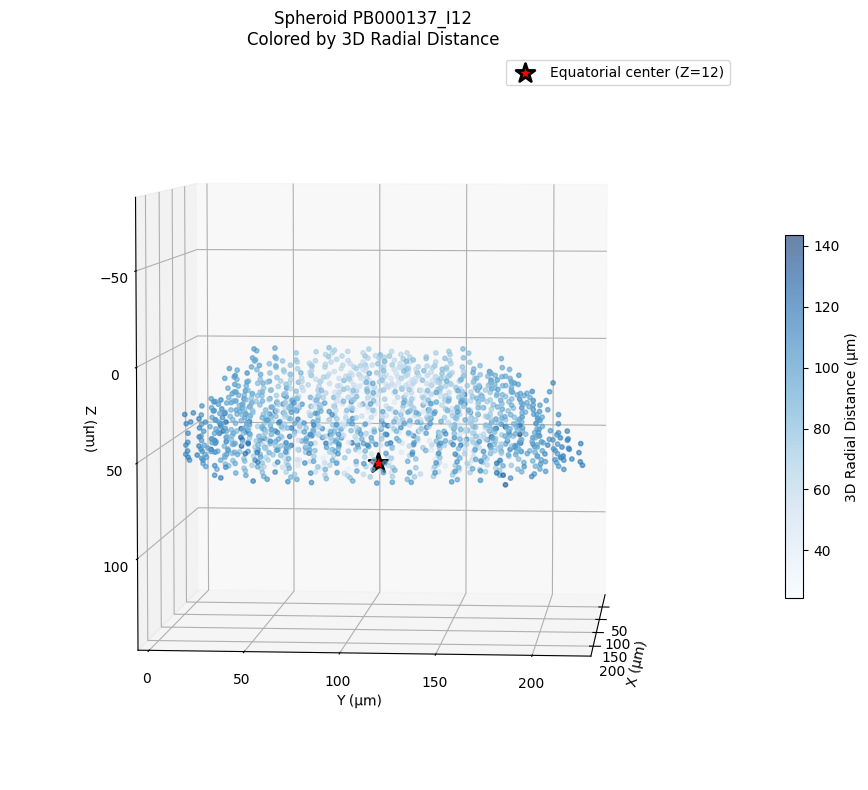

Equatorial plane: Z = 12 (plane index) = 60.0 µm
Center coordinates: X=127.7 µm, Y=110.2 µm, Z=60.0 µm


In [15]:
# Visualize a sample spheroid in 3D colored by 3D radial distance
sample_sph = adata.obs['Metadata_Spheroid_ID'].unique()[7]
sample_mask = adata.obs['Metadata_Spheroid_ID'] == sample_sph
sample_data = adata[sample_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get spatial coordinates and convert to microns
xyz_pixels = sample_data.obsm['spatial_3d']
xyz_um = xyz_pixels.copy()
xyz_um[:, 0] = xyz_pixels[:, 0] * PIXEL_SIZE_UM  # X in µm
xyz_um[:, 1] = xyz_pixels[:, 1] * PIXEL_SIZE_UM  # Y in µm
xyz_um[:, 2] = xyz_pixels[:, 2] * Z_STEP_UM      # Z in µm

radial_dist = sample_data.obs['Metadata_Radial_Distance_3D'].values

# Plot all cells colored by radial distance
scatter = ax.scatter(xyz_um[:, 0], xyz_um[:, 1], xyz_um[:, 2],
                     c=radial_dist, cmap='Blues', s=10, alpha=0.6)

# Get equatorial plane and center coordinates in microns
eq_z = sample_data.obs['Metadata_Equatorial_Z'].iloc[0]
center_info = adata.uns['spheroid_centers'][sample_sph]
center_x_um = center_info['center_x'] * PIXEL_SIZE_UM
center_y_um = center_info['center_y'] * PIXEL_SIZE_UM
center_z_um = eq_z * Z_STEP_UM

# Mark the center point
ax.scatter([center_x_um], [center_y_um], [center_z_um], 
          c='red', s=200, marker='*', edgecolors='black', linewidths=2,
          label=f'Equatorial center (Z={eq_z})')

# Set equal aspect ratio for all axes
# Calculate the range for each axis
x_range = xyz_um[:, 0].max() - xyz_um[:, 0].min()
y_range = xyz_um[:, 1].max() - xyz_um[:, 1].min()
z_range = xyz_um[:, 2].max() - xyz_um[:, 2].min()
max_range = max(x_range, y_range, z_range)

# Center each axis and set equal range
x_mid = (xyz_um[:, 0].max() + xyz_um[:, 0].min()) / 2
y_mid = (xyz_um[:, 1].max() + xyz_um[:, 1].min()) / 2
z_mid = (xyz_um[:, 2].max() + xyz_um[:, 2].min()) / 2

ax.set_xlim(x_mid - max_range/2, x_mid + max_range/2)
ax.set_ylim(y_mid - max_range/2, y_mid + max_range/2)
ax.set_zlim(z_mid - max_range/2, z_mid + max_range/2)

# Set equal aspect ratio
ax.set_box_aspect([1, 1, 1])

# Flip Z axis (top at bottom)
ax.invert_zaxis()

# Set viewing angle
ax.view_init(elev=5, azim=5)

ax.set_xlabel('X (µm)')
ax.set_ylabel('Y (µm)')
ax.set_zlabel('Z (µm)')
ax.set_title(f'Spheroid {sample_sph}\nColored by 3D Radial Distance')
ax.legend()
plt.colorbar(scatter, label='3D Radial Distance (µm)', shrink=0.5)
plt.tight_layout()
plt.show()

print(f"Equatorial plane: Z = {eq_z} (plane index) = {center_z_um:.1f} µm")
print(f"Center coordinates: X={center_x_um:.1f} µm, Y={center_y_um:.1f} µm, Z={center_z_um:.1f} µm")

## Harmony Integration

In [ ]:
from harmony import Harmony
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Harmony with GPU
ho = Harmony(
    X,  # your data matrix
    meta_data,  # metadata dataframe
    batch_key='batch',
    device=device  # specify device
)

# Run correction (will use GPU automatically)
ho.run()
corrected_data = ho.Z_corr

In [25]:
# Check metadata columns to identify treatments
print("Available metadata columns:")
metadata_cols = [col for col in adata.obs.columns if col.startswith('Metadata_')]
for col in sorted(metadata_cols):
    print(f"  {col}: {adata.obs[col].nunique()} unique values")
    if adata.obs[col].nunique() < 20:
        try:
            print(f"    Values: {sorted(adata.obs[col].unique())}")
        except Exception as e:
            print(f"    Could not retrieve values due to error: {e}")
print()

Available metadata columns:
  Metadata_AcqID_cells: 4 unique values
    Values: [4185, 4186, 4188, 4189]
  Metadata_AcqID_cytoplasm: 4 unique values
    Values: [4185, 4186, 4188, 4189]
  Metadata_AcqID_nuclei: 4 unique values
    Values: [4185.0, 4186.0, 4188.0, 4189.0]
  Metadata_Barcode: 4 unique values
    Values: ['PB000137', 'PB000138', 'PB000139', 'PB000140']
  Metadata_Equatorial_Z: 13 unique values
    Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Metadata_PlateWell: 834 unique values
  Metadata_Radial_Distance_3D: 862458 unique values
  Metadata_Site: 13 unique values
    Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Metadata_Spheroid_ID: 834 unique values
  Metadata_Well: 303 unique values
  Metadata_Z: 13 unique values
    Values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
  Metadata_barcode: 4 unique values
    Values: ['PB000137', 'PB000138', 'PB000139', 'PB000140']
  Metadata_cell_line: 1 unique values
    Values: ['HCT116']
  Metadata_cmpd_conc: 10 unique 

In [ ]:
# # Install harmonypy if needed
# try:
#     import harmonypy as hm
#     print("harmonypy already installed")
# except ImportError:
#     print("Installing harmonypy...")
#     import sys
#     !{sys.executable} -m pip install harmonypy
#     import harmonypy as hm
#     print("harmonypy installed successfully")

In [28]:
# Filter to DMSO controls
# TODO: Adjust the column name and value based on the metadata check above
treatment_col = 'Metadata_cmpdname'  # Adjust this based on your metadata
dmso_value = 'dmso'  # Adjust this based on your metadata

if treatment_col in adata.obs.columns:
    adata_dmso = adata[adata.obs[treatment_col] == dmso_value].copy()
    print(f"Filtered to {adata_dmso.n_obs:,} DMSO control cells from {adata_dmso.obs['Metadata_Spheroid_ID'].nunique()} spheroids")
    print(f"Z-planes: {sorted(adata_dmso.obs['Metadata_Z'].unique())}")
else:
    print(f"Column '{treatment_col}' not found. Please check the metadata and update the column name.")
    print("Available columns:", [c for c in adata.obs.columns if 'treatment' in c.lower() or 'compound' in c.lower()])

Filtered to 82,566 DMSO control cells from 58 spheroids
Z-planes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [34]:
# Preprocessing: Handle negative values, log-transform, and standardize
from sklearn.preprocessing import StandardScaler

# Check for negative values
print(f"Data range before preprocessing:")
print(f"  Min: {adata_dmso.X.min():.3f}")
print(f"  Max: {adata_dmso.X.max():.3f}")
print(f"  % negative values: {(adata_dmso.X < 0).sum() / adata_dmso.X.size * 100:.2f}%")

# Clip negative values to 0 (CellProfiler features should be non-negative)
X_clipped = np.clip(adata_dmso.X, 0, None)

# Log-transform (add small constant to avoid log(0))
X_log = np.log1p(X_clipped)

# Check for inf/nan values after log transform
n_inf = np.isinf(X_log).sum()
n_nan = np.isnan(X_log).sum()
print(f"\nAfter log transform:")
print(f"  Inf values: {n_inf}")
print(f"  NaN values: {n_nan}")

# Replace inf/nan with 0
X_log = np.nan_to_num(X_log, nan=0.0, posinf=0.0, neginf=0.0)

# Standardize (z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_log)

print(f"\nPreprocessed data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean():.3f}, Std: {X_scaled.std():.3f}")

Data range before preprocessing:
  Min: -90.000
  Max: 21735.000
  % negative values: 11.08%

After log transform:
  Inf values: 0
  NaN values: 0

Preprocessed data shape: (82566, 2091)
Mean: 0.000, Std: 0.975


In [ ]:
# Run Harmony integration using Z-plane as batch covariate
from harmony import harmonize

# Prepare metadata dataframe with batch variable
meta_data = adata_dmso.obs.copy()
meta_data['Metadata_Z'] = meta_data['Metadata_Z'].astype(str)  # Harmony expects categorical

# Run Harmony using harmony-pytorch
print("Running Harmony integration...")
X_harmony = harmonize(
    X_scaled, 
    meta_data, 
    batch_key='Metadata_Z',  # Column name for batch variable
    random_state=42
)

print(f"\nHarmony-corrected data shape: {X_harmony.shape}")

# Add to adata_dmso
adata_dmso.obsm['X_harmony'] = X_harmony
adata_dmso.obsm['X_scaled'] = X_scaled
print("Stored Harmony embeddings in adata_dmso.obsm['X_harmony']")

Running Harmony integration...
	Initialization is completed.


In [ ]:
# Save the adata
adata_dmso.write_h5ad("HCT116_DMSO_Harmony.h5ad")

In [ ]:
# PCA for visualization: Before and After Harmony
from sklearn.decomposition import PCA

# PCA on scaled data (before Harmony)
pca_before = PCA(n_components=50)
X_pca_before = pca_before.fit_transform(X_scaled)

# PCA on Harmony-corrected data
pca_after = PCA(n_components=50)
X_pca_after = pca_after.fit_transform(X_harmony)

# Store in adata
adata_dmso.obsm['X_pca_before'] = X_pca_before
adata_dmso.obsm['X_pca_after'] = X_pca_after

print("PCA complete:")
print(f"  Before Harmony - Variance explained by PC1-2: {pca_before.explained_variance_ratio_[:2].sum():.1%}")
print(f"  After Harmony - Variance explained by PC1-2: {pca_after.explained_variance_ratio_[:2].sum():.1%}")

In [ ]:
# Visualize: Before vs After Harmony
# Sample cells for faster plotting
n_sample = min(10000, adata_dmso.n_obs)
sample_idx = np.random.choice(adata_dmso.n_obs, n_sample, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Before Harmony - colored by Z-plane
scatter1 = axes[0, 0].scatter(
    X_pca_before[sample_idx, 0], 
    X_pca_before[sample_idx, 1],
    c=adata_dmso.obs['Metadata_Z'].iloc[sample_idx].values,
    cmap='tab20', s=5, alpha=0.5
)
axes[0, 0].set_xlabel('PC1')
axes[0, 0].set_ylabel('PC2')
axes[0, 0].set_title('Before Harmony - colored by Z-plane')
plt.colorbar(scatter1, ax=axes[0, 0], label='Z-plane')

# Before Harmony - colored by radial distance
scatter2 = axes[0, 1].scatter(
    X_pca_before[sample_idx, 0], 
    X_pca_before[sample_idx, 1],
    c=adata_dmso.obs['Metadata_Radial_Distance_3D'].iloc[sample_idx].values,
    cmap='viridis', s=5, alpha=0.5
)
axes[0, 1].set_xlabel('PC1')
axes[0, 1].set_ylabel('PC2')
axes[0, 1].set_title('Before Harmony - colored by Radial Distance')
plt.colorbar(scatter2, ax=axes[0, 1], label='Radial Distance (µm)')

# After Harmony - colored by Z-plane
scatter3 = axes[1, 0].scatter(
    X_pca_after[sample_idx, 0], 
    X_pca_after[sample_idx, 1],
    c=adata_dmso.obs['Metadata_Z'].iloc[sample_idx].values,
    cmap='tab20', s=5, alpha=0.5
)
axes[1, 0].set_xlabel('PC1')
axes[1, 0].set_ylabel('PC2')
axes[1, 0].set_title('After Harmony - colored by Z-plane')
plt.colorbar(scatter3, ax=axes[1, 0], label='Z-plane')

# After Harmony - colored by radial distance
scatter4 = axes[1, 1].scatter(
    X_pca_after[sample_idx, 0], 
    X_pca_after[sample_idx, 1],
    c=adata_dmso.obs['Metadata_Radial_Distance_3D'].iloc[sample_idx].values,
    cmap='viridis', s=5, alpha=0.5
)
axes[1, 1].set_xlabel('PC1')
axes[1, 1].set_ylabel('PC2')
axes[1, 1].set_title('After Harmony - colored by Radial Distance')
plt.colorbar(scatter4, ax=axes[1, 1], label='Radial Distance (µm)')

plt.tight_layout()
plt.show()

print("\nExpected result:")
print("  Top-left: Z-planes should be separated (batch effect)")
print("  Bottom-left: Z-planes should be mixed (batch removed)")
print("  Bottom-right: Radial biology should emerge (gradient)")